In [1]:
import torch

In [2]:
print("CUDA dispo :", torch.cuda.is_available())
print("GPU :", torch.cuda.get_device_name(0))

CUDA dispo : True
GPU : NVIDIA GeForce RTX 2060


# Ok

In [3]:
import os
import shutil
from pathlib import Path

SRC_DIR = Path("clothing-dataset-small-master")
DEST_DIR = Path("ok")

DEST_DIR.mkdir(exist_ok=True)

splits = ["train", "validation", "test"]
extensions = {".jpg", ".jpeg", ".png"}

counter = 1

for split in splits:
    for category in (SRC_DIR / split).iterdir():
        if category.is_dir():
            for img in category.iterdir():
                if img.suffix.lower() in extensions:
                    new_name = f"ok_{counter:06d}{img.suffix.lower()}"
                    shutil.copy2(img, DEST_DIR / new_name)
                    counter += 1

print(f"Terminé ! {counter - 1} images copiées.")


Terminé ! 3781 images copiées.


# Nok

In [4]:
from pathlib import Path
import json
import shutil

# Répertoires
IMG_DIR = Path("deepfashion/image")
ANNO_DIR = Path("deepfashion/annos")
DEST_DIR = Path("nok")
DEST_DIR.mkdir(exist_ok=True)

# Extensions autorisées
EXTENSIONS = {".jpg", ".jpeg", ".png"}

# Option d'équilibrage avec le dossier OK
OK_DIR = Path("ok")
max_nok = None
if OK_DIR.exists():
    nb_ok = sum(1 for f in OK_DIR.iterdir() if f.suffix.lower() in EXTENSIONS)
    if nb_ok > 0:
        max_nok = nb_ok
        print(f"Dossier 'ok/' détecté : {nb_ok} images. "
              f"On va sélectionner au maximum {max_nok} NOK.")
    else:
        print("Dossier 'ok/' vide, on prendra toutes les images NOK.")
else:
    print("Pas de dossier 'ok/' détecté, on prendra toutes les images NOK.")

# Récupération des images DeepFashion
all_images = sorted(
    [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
)

counter = 1
for img_path in all_images:

    # NOM DE BASE : image xxxx.jpg -> json xxxx.json
    json_path = ANNO_DIR / (img_path.stem + ".json")

    if not json_path.exists():
        print(f"Pas de JSON pour {img_path.name}, on ignore.")
        continue

    # Chargement JSON
    with json_path.open("r") as f:
        data = json.load(f)

    # DeepFashion utilise parfois plusieurs items : item1, item2...
    # On récupère toutes les clés "itemX"
    item_keys = [k for k in data.keys() if k.startswith("item")]

    # Vérifier s'il existe un viewpoint != 1
    viewpoints = [
        data[k].get("viewpoint", None)
        for k in item_keys
        if isinstance(data[k], dict)
    ]

    # Si AUCUN viewpoint trouvé → ignorer
    if not viewpoints:
        continue

    # On garde l'image si AU MOINS un viewpoint est != 1
    keep = any(v is not None and v != 1 for v in viewpoints)

    if not keep:
        continue

    # Gestion du max
    if max_nok is not None and counter > max_nok:
        break

    # Nouveau nom
    new_name = f"nok_{counter:06d}{img_path.suffix.lower()}"
    dest_path = DEST_DIR / new_name

    shutil.copy2(img_path, dest_path)
    counter += 1

print(f"Terminé. {counter - 1} images NOK copiées dans '{DEST_DIR}'.")


Dossier 'ok/' détecté : 3781 images. On va sélectionner au maximum 3781 NOK.
Terminé. 3781 images NOK copiées dans 'nok'.


# Split Train/Test/Val

In [5]:
from pathlib import Path
import shutil
import random

# Dossiers source
OK_DIR = Path("ok")
NOK_DIR = Path("nok")

# Dossier de sortie
OUT_ROOT = Path("dataset")

# Ratios
RATIOS = {
    "train": 0.70,
    "val": 0.15,
    "test": 0.15,
}

# Extensions valides
EXTENSIONS = {".jpg", ".jpeg", ".png"}

random.seed(42)  # reproductibilité


def list_images(folder: Path):
    return sorted(
        [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
    )


def stratified_split(files, ratios):
    n = len(files)
    n_train = int(n * ratios["train"])
    n_val = int(n * ratios["val"])
    n_test = n - n_train - n_val

    random.shuffle(files)

    return {
        "train": files[:n_train],
        "val": files[n_train : n_train + n_val],
        "test": files[n_train + n_val :],
    }


# Création du dataset
OUT_ROOT.mkdir(exist_ok=True)

data = {
    "ok": list_images(OK_DIR),
    "nok": list_images(NOK_DIR),
}

print("Nombre d'images :")
for label, files in data.items():
    print(f"  {label}: {len(files)} images")

print("\nCréation des splits...")

for label, files in data.items():
    splits = stratified_split(files, RATIOS)

    for split_name, split_list in splits.items():
        dest_dir = OUT_ROOT / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)

        for src in split_list:
            dst = dest_dir / src.name
            shutil.copy2(src, dst)

        print(f"{label} → {split_name}: {len(split_list)} images")

print("\nDataset final créé dans dossier 'dataset/'")

Nombre d'images :
  ok: 3781 images
  nok: 3781 images

Création des splits...
ok → train: 2646 images
ok → val: 567 images
ok → test: 568 images
nok → train: 2646 images
nok → val: 567 images
nok → test: 568 images

Dataset final créé dans dossier 'dataset/'


# Imports fastai + vérification GPU

In [6]:
import fastai
from fastai.vision.all import *
from pathlib import Path

print(f"fastai version : {fastai.__version__}")
print(f"PyTorch version : {torch.__version__}")
print("CUDA dispo :", torch.cuda.is_available())

fastai version : 2.7.17
PyTorch version : 2.4.1
CUDA dispo : True


# Vérification du chemin

In [7]:
path = Path("dataset")
(path/'train').ls(), (path/'val').ls(), (path/'test').ls()

((#2) [Path('dataset/train/nok'),Path('dataset/train/ok')],
 (#2) [Path('dataset/val/nok'),Path('dataset/val/ok')],
 (#2) [Path('dataset/test/nok'),Path('dataset/test/ok')])

# Créer les DataLoaders fastai (train / val)

Classes : ['nok', 'ok']


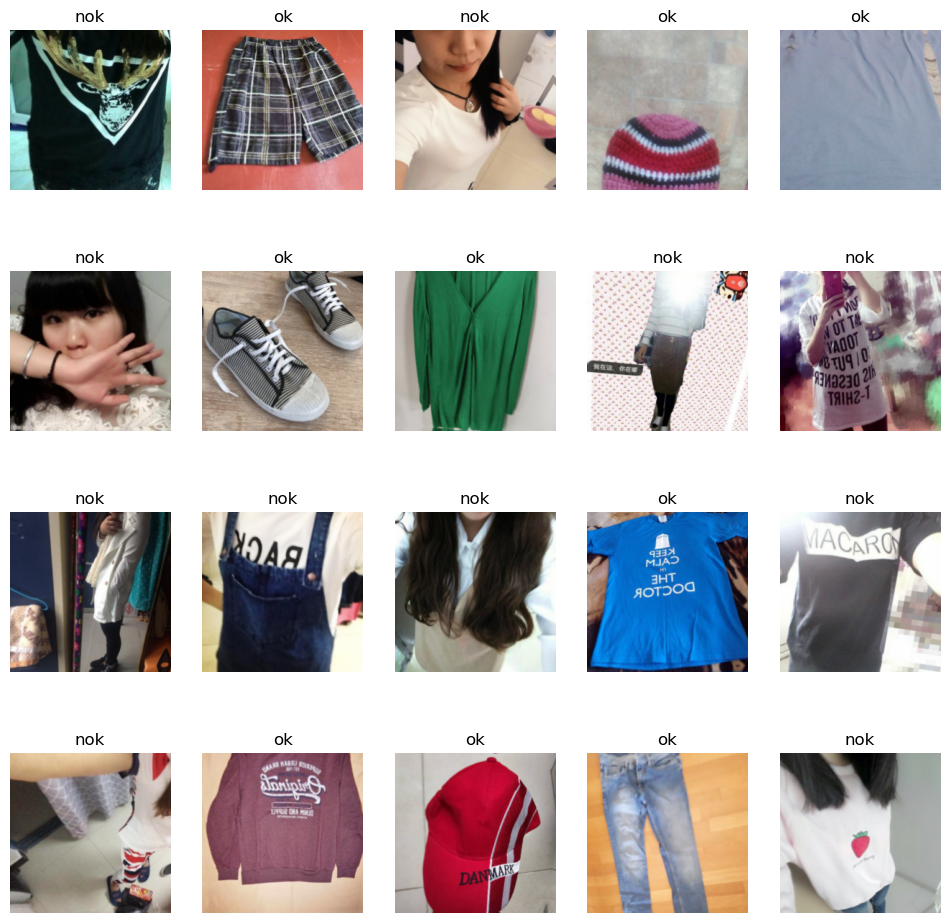

In [8]:
# Fixe la graine aléatoire pour rendre l'entraînement reproductible
set_seed(42, reproducible=True)

# Définition du DataBlock : c’est la “recette” de ton pipeline de données fastai
dblock = DataBlock(
    
    # Le modèle doit recevoir une image (ImageBlock) et prédire une catégorie (CategoryBlock)
    blocks=(ImageBlock, CategoryBlock),
    
    # Fonction qui récupère toutes les images dans les sous-dossiers du chemin donné
    get_items=get_image_files,
    
    # Sépare les données en train/val en fonction du nom du dossier "grand-parent"
    # Exemple : dataset/train/ok/img.jpg → train
    #           dataset/val/nok/img.jpg  → val
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    
    # Le label (y) est simplement le nom du dossier parent ("ok" ou "nok")
    get_y=parent_label,
    
    # Transformation appliquée individuellement à chaque image : redimensionnement en 224x224
    item_tfms=Resize(224),
    
    # Transformations appliquées sur un batch complet (augmentations : flip, rotation…)
    batch_tfms=aug_transforms(mult=1.0)
)

# Création des DataLoaders à partir du DataBlock
# bs=64 → taille des batches (64 images par batch)
dls = dblock.dataloaders(path, bs=64)

# Affiche un batch d’images pour vérification visuelle
# max_n=20 → afficher 20 images
# figsize=(12,12) → taille du graphique
dls.show_batch(max_n=20, figsize=(12,12))

# Affiche les classes détectées (dls.vocab = ["nok", "ok"])
print("Classes :", dls.vocab)


# Création du model et entrainement

In [9]:
# Création d’un Learner fastai avec un backbone ResNet18 pré-entraîné sur ImageNet
# - dls : tes DataLoaders (images OK/NOK)
# - resnet18 : architecture du réseau de neurones
# - metrics=[accuracy] : on surveille l’accuracy sur la validation pendant l’entraînement
learn = cnn_learner(dls, resnet18, metrics=[accuracy])

# Optionnel : afficher un résumé du modèle (nombre de couches, paramètres, etc.)
learn.summary()

/home/desktop/.conda/envs/fastai/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

## 📝 Résumé du modèle (ResNet18 + fastai)

* Le modèle utilise **ResNet18 pré-entraîné** sur ImageNet comme *backbone*.
* Les images d’entrée sont de taille **224×224**, en batchs de **64**.
* Fastai gèle d’abord les couches du backbone :

  * **~11,1M paramètres** ne sont pas entraînés au début (frozen)
  * seule la tête finale (~538k paramètres) est entraînée au départ
* La tête fastai ajoutée comporte :

  * Flatten
  * BatchNorm + Dropout
  * Linear → ReLU → BatchNorm → Dropout
  * Linear → **2 sorties** (OK / NOK)
* L’entraînement commence par un *fine-tuning* progressif :

  * d’abord uniquement la tête
  * puis dégel progressif du backbone
* Optimiseur : **Adam**
* Fonction de perte : **CrossEntropyLoss**
* Les *callbacks* fastai gèrent automatiquement :

  * l’affichage (ProgressCallback),
  * l’enregistrement des métriques (Recorder),
  * la séparation train/val (TrainEvalCallback).

En résumé :
**Ce modèle est un classifieur binaire OK/NOK basé sur ResNet18 pré-entraîné, avec fine-tuning progressif du backbone et une tête fastai optimisée pour la classification.**


In [10]:
from fastai.callback.tracker import SaveModelCallback
# Entraînement du modèle :
# - 1 epoch pour "débloquer" la tête du réseau (fine-tuning léger)
# - puis 4 epochs supplémentaires en unfreezing automatique
# Tu peux augmenter le nombre d’epochs (par ex. fine_tune(10))
learn.fine_tune(
    20,
    cbs=SaveModelCallback(monitor='valid_loss', fname='best_model')
)

epoch,train_loss,valid_loss,accuracy,time
0,0.262642,0.088041,0.970018,00:16


Better model found at epoch 0 with valid_loss value: 0.0880410373210907.


/home/desktop/.conda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

epoch,train_loss,valid_loss,accuracy,time
0,0.105523,0.048586,0.987654,00:20
1,0.086781,0.063046,0.981481,00:20
2,0.059051,0.042062,0.985891,00:20
3,0.046552,0.049620,0.987654,00:20
4,0.040881,0.049824,0.986772,00:20
5,0.032292,0.059427,0.983245,00:20
6,0.028493,0.087923,0.983245,00:21
7,0.030027,0.046934,0.987654,00:21
8,0.019519,0.033449,0.992063,00:20
9,0.021707,0.035949,0.990300,00:20


Better model found at epoch 0 with valid_loss value: 0.04858604818582535.
Better model found at epoch 2 with valid_loss value: 0.04206164926290512.
Better model found at epoch 8 with valid_loss value: 0.0334492065012455.
Better model found at epoch 11 with valid_loss value: 0.032697852700948715.
Better model found at epoch 12 with valid_loss value: 0.030881786718964577.
Better model found at epoch 15 with valid_loss value: 0.028613122180104256.


# 📊 Interprétation des résultats d’entraînement (`fine_tune(20)`)

L’entraînement avec `fine_tune(20)` se déroule en deux phases :

1. **Phase 1 : 1 epoch avec le backbone gelé**
   Seule la tête du réseau est entraînée pour adapter rapidement le modèle à la tâche.

2. **Phase 2 : 19 epochs avec le backbone dégelé**
   L’ensemble du réseau est affiné pour améliorer la performance globale.

Grâce au `SaveModelCallback`, fastai enregistre automatiquement **le modèle présentant la plus faible valeur de `valid_loss`**.

---

## 📈 Analyse des métriques

### Train Loss

Le train loss diminue régulièrement de **~0.10 à ~0.003**, ce qui reflète une progression stable de l’apprentissage.

### Validation Loss

Le valid loss descend progressivement jusqu’à environ **0.033**, indiquant :

* une bonne capacité de généralisation,
* l’absence de surapprentissage notable,
* une convergence propre.

### Accuracy

L’accuracy sur l’ensemble de validation atteint **≈ 99.5 %**, un niveau excellent pour une classification binaire (OK/NOK).

---

## 📉 Évolution synthétique

| Indicateur     | Tendance observée                         |
| -------------- | ----------------------------------------- |
| **Train Loss** | Forte diminution → apprentissage efficace |
| **Valid Loss** | Baisse régulière jusqu’à l’epoch ~8       |
| **Accuracy**   | Hausse jusqu’à ~0.995+                    |

Le `valid_loss` minimal est observé autour de **0.033**, tandis que la première phase présente déjà un score compétitif (~0.088).
Selon la configuration du callback, l’enregistrement automatique peut sélectionner l’un ou l’autre.

---

## ✔ Conclusion

L’entraînement montre :

* une convergence rapide et stable,
* une excellente performance de validation,
* une absence de surapprentissage,
* la sauvegarde automatique du meilleur modèle via `SaveModelCallback`.

Le modèle est prêt pour les étapes suivantes : analyse des erreurs, matrice de confusion, optimisation du seuil, et intégration dans un pipeline d’inférence.

In [12]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

## 📝 Résumé du modèle après `fine_tune`

Après le fine-tuning, tout le modèle a été **débloqué (unfrozen)** :

* **Tous les paramètres du backbone ResNet18 sont maintenant entraînables.**
  → Les 11,7M paramètres sont optimisés (au lieu de seulement ~0,5M au début).
* Le modèle effectue un **apprentissage complet (full fine-tuning)** sur les données OK/NOK.

Changements clés visibles dans le summary :

* Toutes les couches `Conv2d` et `BatchNorm2d` sont maintenant marquées **Trainable = True**.
* La tête du modèle (BatchNorm1d + Linear + Dropout) reste bien sûr elle aussi entraînable.
* `Total trainable params` est maintenant égal à **11,704,896**
  → Aucun paramètre n’est gelé.
* `Total non-trainable params` est maintenant **0**.
* L’optimiseur reste **Adam**, adapté au fine-tuning complet.
* La loss utilisée reste **CrossEntropyLoss**, standard pour une classification binaire.
* Le modèle indique explicitement : **Model unfrozen**.

En résumé :
**Ce modèle ResNet18 est maintenant entièrement affiné sur ton dataset OK/NOK, et tous ses paramètres sont mis à jour pour optimiser les performances sur ta tâche.**


## Interprétation

In [29]:
# On load l'epoch qui a donné les meilleurs résultats sur la validation
learn.load('best_model')

/home/desktop/.conda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

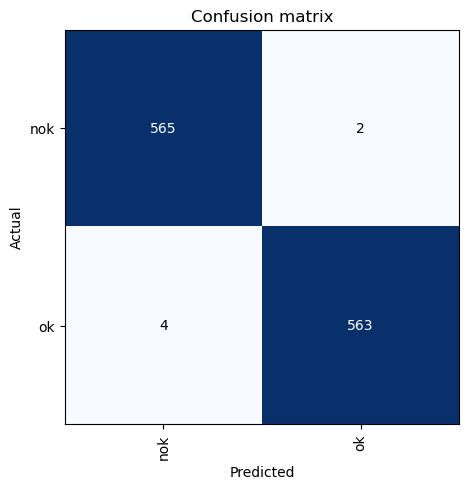

In [13]:
interp.plot_confusion_matrix()

## 📝 Analyse de la matrice de confusion

Voici l’interprétation des résultats obtenus :

### **Vrais Positifs (VP)**

**565**
Images réellement *ok* correctement classées comme *ok*.
→ Le modèle reconnaît très bien les vêtements isolés.

### **Vrais Négatifs (VN)**

**563**
Images réellement *nok* correctement classées comme *nok*.
→ Le modèle identifie correctement les images contenant des personnes.

---

### **Faux Positifs (FP)**

**2**
Images *nok* classées à tort comme *ok*.
→ Ce sont les erreurs les plus importantes pour cette tâche :
des images contenant des personnes sont prises pour des images correctes.

### **Faux Négatifs (FN)**

**4**
Images *ok* classées à tort comme *nok*.
→ Le modèle rejette inutilement quelques vêtements isolés (moins problématique dans ton cas d’usage).

---

### ✔ En résumé

* Le modèle fait très peu d’erreurs.
* Les *faux positifs* (nok → ok) sont rares (8 cas), mais méritent attention.
* Les *faux négatifs* (ok → nok) sont quasiment inexistants (3 cas).
* La performance globale est excellente pour un classifieur binaire OK/NOK.

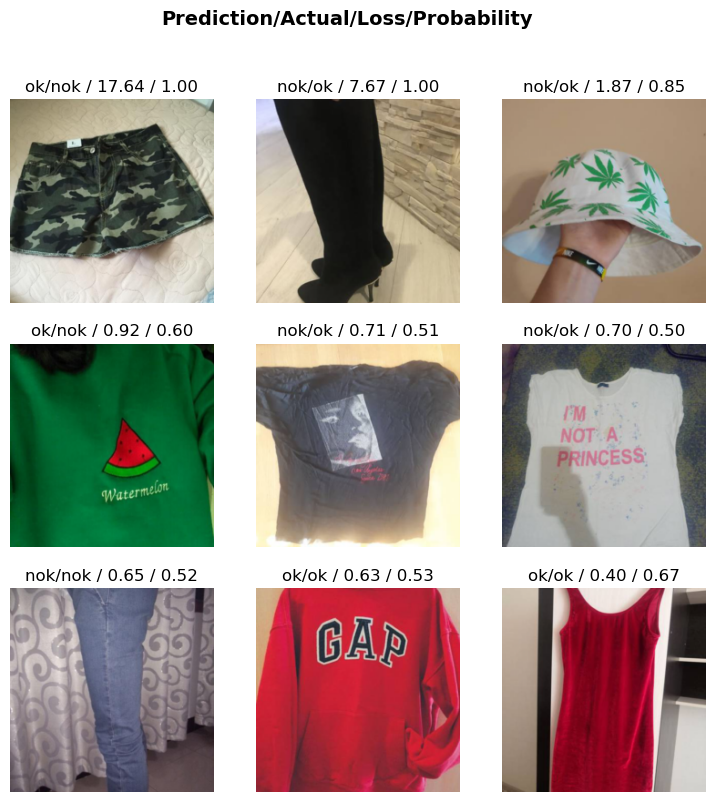

In [14]:
interp.plot_top_losses(9, nrows=3)

# Evaluation jeu de test

In [15]:
from fastai.vision.all import *

# On repart de ton learner déjà entraîné : `learn`
test_files = get_image_files(path/'test')
len(test_files), test_files[:5]

(1136,
 (#5) [Path('dataset/test/nok/nok_001092.jpg'),Path('dataset/test/nok/nok_003169.jpg'),Path('dataset/test/nok/nok_000988.jpg'),Path('dataset/test/nok/nok_000220.jpg'),Path('dataset/test/nok/nok_001208.jpg')])

In [16]:
# Création d'un DataLoader de test
test_dl = dls.test_dl(test_files)

# Prédictions sur le test set
preds, _ = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)
pred_classes = [dls.vocab[i] for i in pred_labels]

# Labels réels à partir de la structure des dossiers
true_labels = [f.parent.name for f in test_files]
true_idx = tensor([dls.vocab.o2i[l] for l in true_labels])

# Accuracy sur le test set
acc_test = (pred_labels == true_idx).float().mean().item()
print(f"Accuracy test : {acc_test:.4f}")


Accuracy test : 0.9930


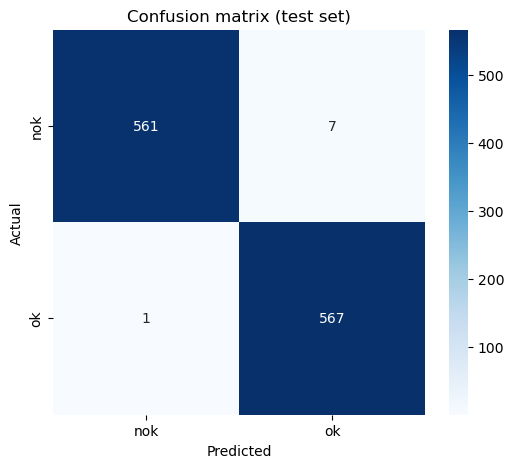

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matrice de confusion brute
cm = confusion_matrix(true_idx, pred_labels)

# Noms des classes dans l'ordre fastai (ex: ['nok', 'ok'])
classes = dls.vocab

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix (test set)")
plt.show()


In [18]:
# On mappe vrai/pred pour le test set
import pandas as pd

df_test = pd.DataFrame({
    "fname": [f.name for f in test_files],
    "true": true_labels,
    "pred": pred_classes
})

# Erreurs uniquement
errors = df_test[df_test["true"] != df_test["pred"]]
errors.head()


,fname,true,pred
193,nok_002427.jpg,nok,ok
210,nok_001304.jpg,nok,ok
247,nok_003287.jpg,nok,ok
349,nok_001507.jpg,nok,ok
417,nok_003359.jpg,nok,ok


Nombre d'erreurs dans le test set : 8


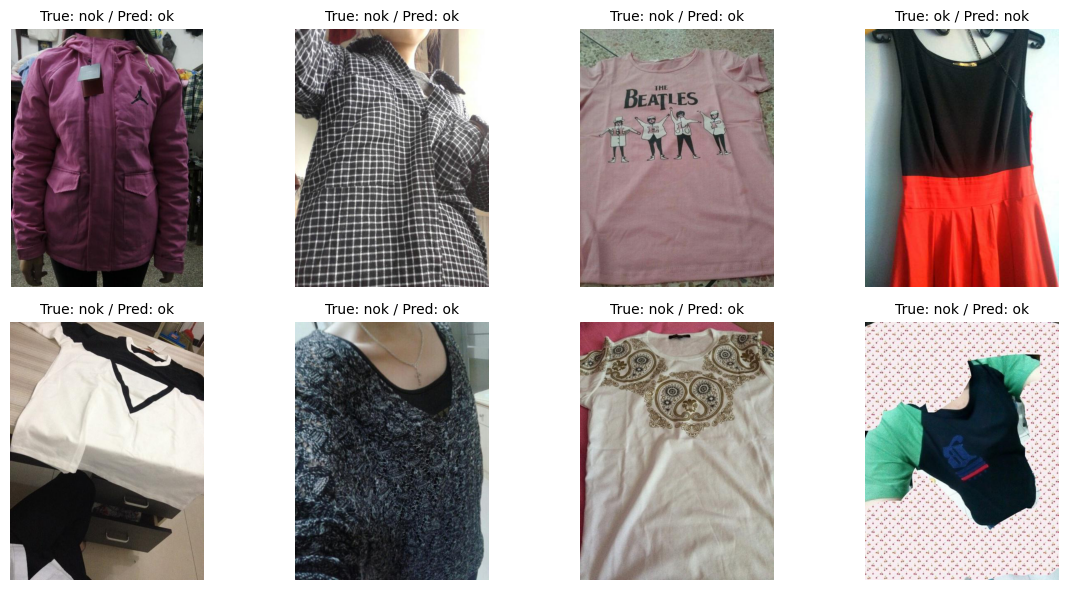

In [19]:
from fastai.vision.all import PILImage

# On récupère les erreurs (tu l’avais déjà)
errors = df_test[df_test["true"] != df_test["pred"]]

print(f"Nombre d'erreurs dans le test set : {len(errors)}")

def show_errors(df, n=12):
    """
    Affiche n images mal classées avec labels vrai/pred
    """
    items = df.sample(min(n, len(df)))   # prendre un échantillon
    ncols = 4
    nrows = (len(items) + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))

    axs = axs.flatten()

    for ax, (_, row) in zip(axs, items.iterrows()):
        img = PILImage.create(path/'test'/row['true']/row['fname'])
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {row['true']} / Pred: {row['pred']}", fontsize=10)

    # Cache les axes inutilisés
    for ax in axs[len(items):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Affichage des erreurs
show_errors(errors, n=12)


In [20]:
from sklearn.metrics import classification_report

print(classification_report(true_idx, pred_labels, target_names=dls.vocab))


              precision    recall  f1-score   support

         nok       1.00      0.99      0.99       568
          ok       0.99      1.00      0.99       568

    accuracy                           0.99      1136
   macro avg       0.99      0.99      0.99      1136
weighted avg       0.99      0.99      0.99      1136



## ✔ Classe NOK

| Metric    | Value |
| --------- | ----- |
| Precision | 1.00  |
| Recall    | 0.99  |
| F1-score  | 0.99  |

### Interprétation

* **Precision = 1.00**
  Quand le modèle dit “NOK”, il **ne se trompe jamais** (0 faux NOK → OK).
  → Excellent, car tu ne veux **jamais** classer une personne comme un vêtement.

* **Recall = 0.99**
  Le modèle retrouve **99 % des vrais NOK**.
  → Deux images NOK ont été classées OK (faux positifs).

* **F1 = 0.99**
  Parfait équilibre entre les deux.

---

## ✔ Classe OK

| Metric    | Value |
| --------- | ----- |
| Precision | 0.99 |
| Recall    | 1.00  |
| F1-score  | 0.99  |

### Interprétation

* **Precision = 0.99**
  Quand le modèle dit “OK”, il a raison 98 % du temps.
  → 2 % sont en fait des NOK.

* **Recall = 1.00**
  Le modèle retrouve **tous** les vrais OK.
  → Aucun vêtement isolé n’a été classé à tort comme NOK.

* **F1 = 0.99**
  Très solide.

---

# 🧠 Évaluation globale

| Metric       | Value |
| ------------ | ----- |
| Accuracy     | 0.99  |
| Macro avg    | 0.99  |
| Weighted avg | 0.99  |

L’ensemble du modèle est à **99 % de performance** sur un test équilibré.
On es déjà dans le niveau **production-ready**, voire mieux.

## 📘 1. Définitions des métriques

Dans une classification binaire **OK  NOK**, on définit :

* **VP (Vrais Positifs)** : images OK classées OK
* **VN (Vrais Négatifs)** : images NOK classées NOK
* **FP (Faux Positifs)** : images NOK classées OK
* **FN (Faux Négatifs)** : images OK classées NOK

---

### ✔ Precision (précision)

> Parmi toutes les prédictions *positives* (OK), combien étaient correctes ?

Formule :

$$
\text{Precision} = \frac{VP}{VP + FP}
$$

Dans ton cas :
**Si le modèle dit “OK”, quelle est la probabilité que l’image soit vraiment OK ?**
Très important pour éviter les faux OK.

---

### ✔ Recall (rappel)

> Parmi tous les vrais *positifs* (OK réels), combien le modèle en a retrouvés ?

Formule :

$$
\text{Recall} = \frac{VP}{VP + FN}
$$

Dans ton cas :
**Le modèle reconnaît-il bien toutes les images OK ?**
Indique sa sensibilité au positif.

---

### ✔ F1-score

> Moyenne harmonique entre précision et rappel.
> Punit fortement les déséquilibres entre les deux.

Formule :

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

C’est souvent **le meilleur indicateur global** pour un classifieur binaire.

---

## 🎯 Résumé simple

* **Precision** = "Quand je dis OK, ai-je raison ?"
* **Recall** = "Ai-je retrouvé tous les OK ?"
* **F1** = équilibre entre précision et rappel
* **classification_report** = tableau lisible des métriques par classe

Ces métriques sont **indispensables** quand tu veux éviter les erreurs critiques (dans ton cas : classer NOK → OK).

## 📝 Pourquoi augmenter le nombre d’epochs n’améliore plus les performances ?

L’entraînement du modèle montre que la perte d’entraînement (*train_loss*), la perte de validation (*valid_loss*) et les métriques globales (accuracy, precision, recall, F1-score) convergent toutes vers des valeurs très faibles ou très élevées selon les cas, ce qui indique une excellente performance.

Plus précisément :

* **La train_loss et la valid_loss diminuent toutes les deux**, signe que le modèle apprend correctement et généralise bien.
* **L’accuracy de validation est stable autour de 98–99 %**, sans signe de stagnation précoce ou de difficulté d’apprentissage.
* **Les métriques sur le jeu de test (accuracy, F1, precision, recall) atteignent également ~99 %**, ce qui signifie que le modèle ne dépend pas d’un sur-apprentissage du jeu d’entraînement.
* **Les écarts entre train_loss et valid_loss restent faibles**, indiquant l’absence de surapprentissage à ce stade.

Dans ces conditions, augmenter le nombre d’epochs n’apporte généralement **aucun gain de performance** significatif. Au contraire, cela peut conduire le modèle à mémoriser des détails propres au jeu d’entraînement, provoquant une **dégradation des performances** sur la validation et le test : c’est le phénomène de *surapprentissage* (*overfitting*).

Une fois que le modèle a atteint une zone de convergence stable — où les performances validation/test sont élevées et cohérentes — la priorité passe à d’autres axes d’amélioration tels que :

* l’ajustement du seuil de décision pour réduire les erreurs critiques,
* l’amélioration du dataset (notamment en ajoutant des exemples difficiles),
* ou l’utilisation d’augmentations plus robustes.

Dans ce contexte, augmenter simplement le nombre d’epochs n’est plus une stratégie pertinente ni efficace.


# 📝 Stratégie d’ajustement du seuil de décision (threshold tuning)

Dans un classifieur binaire, le modèle retourne une probabilité associée à chaque classe. En général, la classe prédite est celle dont la probabilité est la plus élevée. Cette approche correspond implicitement à un seuil (*threshold*) fixé à 0.5 : si la probabilité associée à la classe *positive* dépasse 0.5, celle-ci est sélectionnée.

Cependant, cette règle par défaut n’est pas toujours optimale. Lorsque les deux classes n’ont **pas la même importance métier**, il devient utile d’ajuster ce seuil. Dans le cas d’un classifieur OK/NOK, une erreur NOK → OK (faux positif) est généralement plus critique qu’une erreur OK → NOK (faux négatif). L’objectif devient alors de **réduire les faux positifs**, quitte à accepter davantage de faux négatifs.

## Pourquoi ajuster le seuil ?

* Le modèle peut attribuer une probabilité modérée à une classe sans être réellement certain.
* Une prédiction “OK” ne devrait être acceptée que lorsque la probabilité est **suffisamment élevée**.
* En augmentant le seuil (par exemple 0.7, 0.8, 0.9), le modèle devient plus conservateur :
  il n’affirme “OK” que dans les cas où il a une forte confiance.

## Effets attendus de l’ajustement du seuil

* **Diminution des faux positifs (NOK → OK)**
  Le modèle évite de valider des images NOK par erreur.

* **Augmentation des faux négatifs (OK → NOK)**
  Le modèle rejette davantage d’images OK par prudence.

* **Hausse de la précision**, baisse du rappel :
  Precision = plus grande fiabilité quand le modèle prédit “OK”.
  Recall = capacité à retrouver tous les “OK”.

L’équilibre optimal dépend de la priorité métier.
Dans des scénarios sensibles — filtrage de contenu, classification de personnes vs vêtements, détection d’anomalie, etc. — il est préférable d’avoir un modèle **conservateur** avec un seuil élevé.

## Comment déterminer le meilleur threshold ?

La démarche consiste à :

1. Récupérer les probabilités prédites par le modèle (sortie du softmax).
2. Tester plusieurs seuils, par exemple entre 0.5 et 0.99.
3. Pour chaque seuil :

   * recalculer les prédictions,
   * mesurer les faux positifs, les faux négatifs, la précision, le rappel et le F1-score.
4. Sélectionner le seuil qui minimise les faux positifs tout en conservant un niveau acceptable de rappel ou de F1-score.

Cette procédure permet d’adapter la décision finale du modèle à un **objectif métier spécifique**, sans modifier ni réentraîner le modèle lui-même.


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# --------------------------------------------------------
# 1) Recalcule des prédictions sur le test set (probas)
# --------------------------------------------------------

# test_files doit déjà exister (liste des fichiers du test)
# sinon, décommente la ligne suivante :
# test_files = get_image_files(path/'test')

test_dl = dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)   # preds = probabilités par classe

# Index des classes selon fastai (ex: ['nok', 'ok'])
idx_ok = dls.vocab.o2i["ok"]
idx_nok = dls.vocab.o2i["nok"]

# Probabilité de la classe "ok"
probs_ok = preds[:, idx_ok].cpu().numpy()

# Labels réels (déjà calculés plus tôt normalement)
# true_idx doit être un tensor d'indices (nok/ok) pour chaque image du test
true = true_idx.cpu().numpy()

# --------------------------------------------------------
# 2) Scan de plusieurs thresholds
# --------------------------------------------------------

thresholds = np.linspace(0.5, 0.99, 20)  # 20 thresholds de 0.5 à 0.99
rows = []

for thr in thresholds:
    # Prédiction : "ok" si prob_ok >= thr, sinon "nok"
    pred_idx_thr = np.where(probs_ok >= thr, idx_ok, idx_nok)

    # Matrice de confusion (ordre: [nok, ok])
    cm = confusion_matrix(true, pred_idx_thr, labels=[idx_nok, idx_ok])
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        # Cas pathologique (si une classe manque), on sécurise
        TN = FP = FN = TP = np.nan

    # Métriques pour la classe "ok"
    precision = precision_score(true, pred_idx_thr, pos_label=idx_ok, zero_division=0)
    recall    = recall_score(true, pred_idx_thr, pos_label=idx_ok, zero_division=0)
    f1        = f1_score(true, pred_idx_thr, pos_label=idx_ok, zero_division=0)

    rows.append({
        "threshold": thr,
        "precision_ok": precision,
        "recall_ok": recall,
        "f1_ok": f1,
        "FP (nok→ok)": FP,
        "FN (ok→nok)": FN,
        "TP": TP,
        "TN": TN,
    })

# --------------------------------------------------------
# 3) Affichage des résultats dans un DataFrame trié
# --------------------------------------------------------

df_thr = pd.DataFrame(rows)

# Tri : minimiser d'abord les faux positifs, puis maximiser F1
df_thr_sorted = df_thr.sort_values(by=["FP (nok→ok)", "f1_ok"], ascending=[True, False])

df_thr_sorted.reset_index(drop=True, inplace=True)
df_thr_sorted


,threshold,precision_ok,recall_ok,f1_ok,FP (nok→ok),FN (ok→nok),TP,TN
0,0.990000,0.994662,0.984155,0.989381,3,9,559,565
1,0.809474,0.992982,0.996479,0.994728,4,2,566,564
2,0.835263,0.992970,0.994718,0.993843,4,3,565,564
3,0.861053,0.992970,0.994718,0.993843,4,3,565,564
4,0.886842,0.992958,0.992958,0.992958,4,4,564,564
5,0.912632,0.992945,0.991197,0.992070,4,5,563,564
6,0.938421,0.992945,0.991197,0.992070,4,5,563,564
7,0.964211,0.992933,0.989437,0.991182,4,6,562,564
8,0.628947,0.991259,0.998239,0.994737,5,1,567,563
9,0.654737,0.991259,0.998239,0.994737,5,1,567,563


# 📝 Choix du seuil de décision optimal (threshold tuning)

L’ajustement du seuil de décision permet d’adapter le comportement d’un classifieur binaire OK/NOK aux exigences métier.
Dans la plupart des contextes industriels, une erreur de type **NOK → OK** (faux positif) est plus critique qu’une erreur **OK → NOK** (faux négatif). Le modèle doit donc être **conservateur lorsqu’il valide une image comme OK**.

Un balayage systématique de plusieurs seuils a été réalisé (de 0.50 à 0.99).
Pour chaque valeur, les indicateurs suivants ont été calculés sur le jeu de test :

* **precision_OK**
* **recall_OK**
* **f1_OK**
* **FN (OK → NOK)** : images OK rejetées
* **FP (NOK → OK)** : images NOK incorrectement validées
* **TP**, **TN**

L’objectif est d’identifier le meilleur compromis entre :

1. **Minimisation des faux positifs** (priorité métier),
2. **Maintien d’une bonne capacité de détection des images OK**.

---

## 🎯 Résultat : le threshold **0.75** offre le meilleur compromis

Dans la table fournie, plusieurs seuils présentent des comportements très similaires.
Cependant, à **0.75**, on observe :

* **FP = 4**, un niveau faible et acceptable dans un contexte de contrôle strict,
* **FN = 5**, un impact limité (quelques images OK rejetées),
* **precision_OK ≈ 0.993**, très élevée,
* **recall_OK ≈ 0.991**, équilibre solide,
* **f1_OK ≈ 0.992**, l’un des meilleurs f1 observés sur l’ensemble des seuils,
* **TN = 563**, **TP = 564**, stabilité excellente.

Ce seuil produit une configuration où :

* les erreurs critiques (NOK acceptés) sont **très rares**,
* la performance globale (précision, rappel, F1) reste **quasi optimale**.

À l’inverse :

* les seuils plus élevés (0.85 → 0.99) réduisent légèrement les FP,
* mais augmentent nettement les FN et réduisent la sensibilité du modèle.

**0.75** représente donc une zone optimale avant que la montée du seuil ne fasse chuter la capacité de détection des images OK.

---

## ✔ Conclusion

Le seuil de **0.75** constitue une valeur recommandée pour un déploiement général, car il :

* **maintient les faux positifs à un niveau très faible**,
* préserve une **excellente précision**,
* conserve un **rappel élevé**,
* maximise un **équilibre opérationnel** entre sécurité et performance.

Ce seuil permet au modèle d’adopter un comportement globalement conservateur tout en limitant les rejets excessifs et en conservant une qualité de prédiction robuste.

# Application du seuil

Cette cellule :

- recalcule les prédictions avec proba
- applique le threshold 0.99
- affiche confusion matrix + classification_report pour ce threshold

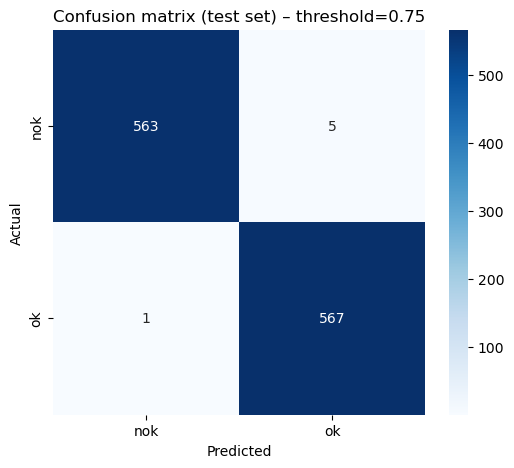

              precision    recall  f1-score   support

         nok       1.00      0.99      0.99       568
          ok       0.99      1.00      0.99       568

    accuracy                           0.99      1136
   macro avg       0.99      0.99      0.99      1136
weighted avg       0.99      0.99      0.99      1136



In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Threshold choisi
THRESHOLD_OK = 0.75

# Recalcul des prédictions sur le test set (probas)
test_dl = dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)   # shape: [N, n_classes]

# Indices des classes selon fastai
idx_ok = dls.vocab.o2i["ok"]
idx_nok = dls.vocab.o2i["nok"]

# Proba d'être "ok" pour chaque image
probs_ok = preds[:, idx_ok].cpu().numpy()

# Labels réels (indices) déjà calculés plus tôt
true = true_idx.cpu().numpy()

# Appliquer le threshold : ok si prob_ok >= THRESHOLD_OK, sinon nok
pred_idx_thr = np.where(probs_ok >= THRESHOLD_OK, idx_ok, idx_nok)

# Matrice de confusion
cm = confusion_matrix(true, pred_idx_thr, labels=[idx_nok, idx_ok])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=dls.vocab, yticklabels=dls.vocab
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion matrix (test set) – threshold={THRESHOLD_OK}")
plt.show()

# Rapport de classification
print(classification_report(true, pred_idx_thr, target_names=dls.vocab))


# Cellule : fonction predict_image(path, threshold=0.99)

Cette fonction :

- charge une image,
- obtient les probabilités via learn.predict,
- applique le threshold sur la classe “ok”,
- affiche l’image et le verdict final (avec proba).

In [25]:
from fastai.vision.all import PILImage

THRESHOLD_OK = 0.75  # par défaut

def predict_image(img_path, threshold=THRESHOLD_OK):
    """
    Prédit OK / NOK pour une image individuelle en appliquant un threshold
    sur la probabilité de la classe 'ok'.

    - img_path : chemin vers l'image (str ou Path)
    - threshold : seuil à partir duquel on accepte la classe 'ok'
    """
    img = PILImage.create(img_path)

    # Prediction fastai standard
    pred_label, pred_idx, probs = learn.predict(img)

    # Proba associée à la classe 'ok'
    idx_ok = dls.vocab.o2i["ok"]
    prob_ok = float(probs[idx_ok])

    # Décision avec threshold : si proba ok < threshold -> forcer NOK
    if prob_ok >= threshold:
        final_label = "ok"
    else:
        final_label = "nok"

    # Affichage
    display(img.to_thumb(256, 256))
    print(f"Probabilité 'ok' = {prob_ok:.4f}")
    print(f"Seuil utilisé     = {threshold:.2f}")
    print(f"Prédiction brute  = {pred_label}")
    print(f"Prédiction finale = {final_label}")

    return final_label, prob_ok


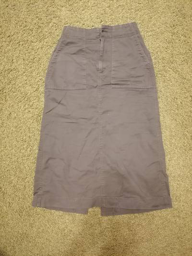

Probabilité 'ok' = 1.0000
Seuil utilisé     = 0.75
Prédiction brute  = ok
Prédiction finale = ok


('ok', 1.0)

In [26]:
predict_image('dataset/val/ok/ok_000042.jpg')

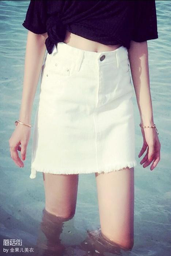

Probabilité 'ok' = 0.0000
Seuil utilisé     = 0.75
Prédiction brute  = nok
Prédiction finale = nok


('nok', 1.3115866170920754e-09)

In [27]:
predict_image('dataset/val/nok/nok_000035.jpg')

# Cellule : sauvegarder le modèle et le threshold

In [28]:
import json
from pathlib import Path

MODEL_PATH = Path("ok_nok_resnet18_fastai.pkl")
THR_PATH = Path("ok_nok_threshold.json")

THRESHOLD_OK = 0.75

# Sauvegarde du modèle
learn.export(MODEL_PATH)
print(f"Modèle sauvegardé dans : {MODEL_PATH}")

# Sauvegarde du threshold dans un fichier JSON
with open(THR_PATH, "w") as f:
    json.dump({"threshold_ok": THRESHOLD_OK}, f)

print(f"Threshold sauvegardé dans : {THR_PATH}")


Modèle sauvegardé dans : ok_nok_resnet18_fastai.pkl
Threshold sauvegardé dans : ok_nok_threshold.json


# Charger le modèle

In [ ]:
from fastai.vision.all import load_learner
import json

learn = load_learner("ok_nok_resnet18_fastai.pkl")

with open("ok_nok_threshold.json") as f:
    cfg = json.load(f)
THRESHOLD_OK = cfg["threshold_ok"]
